<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Jet%20Classification%20with%20pt%20meta%20task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pennylane h5py --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 114.1 MB/s eta 0:00:00


In [2]:
# Standard imports
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict, Any
from dataclasses import dataclass
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans

# Mount Google Drive (if running in Colab)
from google.colab import drive
drive.mount('/content/drive')

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Mounted at /content/drive


In [14]:
@dataclass
class Config:
  SAMPLES: int = 20000         # Reduced dataset size for faster processing
  NUM_QUBITS: int = 6          # Slightly fewer qubits for faster quantum simulation
  Q_DEPTH: int = 4             # Reduced quantum circuit depth
  ENCODING_SCHEME: str = 'angle'
  USE_ANALYTIC_GRADIENTS: bool = True
  CNN_OUTPUT_DIM: int = 256    # Moderate CNN feature size
  USE_PRETRAINED_CNN: bool = True  # Keep ResNet18 for strong feature extraction
  INNER_STEPS: int = 5         # Fewer inner-loop steps for faster adaptation
  INNER_LR: float = 0.005      # Slightly higher inner-loop learning rate for faster convergence
  OUTER_LR: float = 0.0005     # Slightly higher outer-loop learning rate
  META_TASK_TYPE: str = 'pt'
  META_BIN_COUNT: int = 10     # Reduced number of bins for faster meta-task generation
  META_TASK_STRATEGY: str = 'binning'
  SUPPORT_SIZE: int = 32       # Reduced support set size
  QUERY_SIZE: int = 32         # Reduced query set size
  EPOCHS: int = 10             # Fewer epochs for faster training
  BATCH_SIZE: int = 32         # Smaller batch size for faster computation
  EVAL_METRICS: bool = True
  USE_TEST2: bool = True
  SAVE_BEST_MODEL: bool = True
  CHECKPOINT_DIR: str = '/content/drive/MyDrive/quark-gluon-checkpoints'
config = Config()
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)

In [4]:
class JetDataset(Dataset):
    """Custom Dataset for loading jet images, labels, and additional features."""
    def __init__(self, X: np.ndarray, y: np.ndarray, pt: np.ndarray = None, m0: np.ndarray = None):
        self.X = X
        self.y = y
        self.pt = pt
        self.m0 = m0

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        return self.X[idx], self.y[idx]

def load_and_merge_datasets(config: Config) -> Tuple[Dataset, Dataset]:
    """Load and merge datasets for meta-task generation."""
    # Paths to datasets
    train_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_train-set_n793900.hdf5'
    test1_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n139306.hdf5'
    test2_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n10000.hdf5'

    # Load train and test1 datasets
    with h5py.File(train_path, 'r') as f:
        X_train = f['X_jets'][:config.SAMPLES]
        if X_train.shape[-1] != 3:  # Fix channel dimension if needed
            X_train = X_train[..., :3]  # Keep only the first 3 channel
        y_train = f['y'][:config.SAMPLES]
        pt_train = f['pt'][:config.SAMPLES]
        m0_train = f['m0'][:config.SAMPLES]

    with h5py.File(test1_path, 'r') as f:
        X_test1 = f['X_jets'][:config.SAMPLES]
        if X_test1.shape[-1] != 3:  # Fix channel dimension if needed
            X_test1 = X_test1[..., :3]  # Keep only the first 3 channels
        y_test1 = f['y'][:config.SAMPLES]
        pt_test1 = f['pt'][:config.SAMPLES]
        m0_test1 = f['m0'][:config.SAMPLES]

    # Merge train and test1
    X_meta = np.concatenate([X_train, X_test1], axis=0)
    y_meta = np.concatenate([y_train, y_test1], axis=0)
    pt_meta = np.concatenate([pt_train, pt_test1], axis=0)
    m0_meta = np.concatenate([m0_train, m0_test1], axis=0)

    # Load test2 dataset
    with h5py.File(test2_path, 'r') as f:
        X_test2 = f['X'][:config.SAMPLES]
        if X_test2.shape[-1] != 3:  # Fix channel dimension if needed
            X_test2 = X_test2[..., :3]  # Keep only the first 3 channels
        y_test2 = f['y'][:config.SAMPLES]

    # Create datasets
    meta_dataset = JetDataset(X_meta, y_meta, pt_meta, m0_meta)
    test2_dataset = JetDataset(X_test2, y_test2)

    return meta_dataset, test2_dataset

# Load datasets
meta_dataset, test2_dataset = load_and_merge_datasets(config)

In [5]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, output_dim: int, num_qubits: int, use_pretrained: bool = False):
        super().__init__()
        print("Entered CNNFeatureExtractor __init__")
        self.use_pretrained = use_pretrained
        if use_pretrained:
            self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
            self.model.fc = nn.Linear(self.model.fc.in_features, num_qubits)
        else:
            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            self.output_dim = output_dim
            self.num_qubits = num_qubits
            self.fc1 = None
            self.fc2 = None

    def _build_fc_layers(self, x):
        flatten_size = x.shape[1]
        self.fc1 = nn.Linear(flatten_size, self.output_dim).to(x.device)
        self.fc2 = nn.Linear(self.output_dim, self.num_qubits).to(x.device)

    def forward(self, x):
        if self.use_pretrained:
            x = x.permute(0, 3, 1, 2)  # Fix shape for ResNet (batch_size, channels, height, width)
            out = self.model(x)
            return out
        else:
            x = x.permute(0, 3, 1, 2)  # Fix shape for custom CNN (batch_size, channels, height, width)
            x = self.pool(torch.relu(self.conv1(x)))
            x = self.pool(torch.relu(self.conv2(x)))
            x = self.pool(torch.relu(self.conv3(x)))
            x = x.contiguous().view(x.size(0), -1)
            # Build FC layers on first forward if not already built
            if self.fc1 is None or self.fc2 is None:
                self._build_fc_layers(x)
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            return x

In [6]:
class PQCModel(nn.Module):
    def __init__(self, num_qubits, depth, encoding_scheme, use_analytic_gradients):
        super().__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.encoding_scheme = encoding_scheme
        self.use_analytic_gradients = use_analytic_gradients
        self.dev = qml.device("default.qubit", wires=num_qubits)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            if encoding_scheme == 'angle':
                for i in range(num_qubits):
                    qml.RY(inputs[i], wires=i)
            elif encoding_scheme == 'amplitude':
                qml.AmplitudeEmbedding(inputs, wires=range(num_qubits), normalize=True)
            else:
                raise ValueError("Invalid encoding scheme.")
            qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
            return qml.expval(qml.PauliZ(0))
        self.circuit = circuit
        self.weights = nn.Parameter(torch.randn(depth, num_qubits, 3))
        self.fc = nn.Linear(1, 2)

    def forward(self, x):
        batch_size = x.size(0)
        outputs = torch.zeros(batch_size, 1)
        for i in range(batch_size):
            outputs[i] = self.circuit(x[i], self.weights)
        logits = self.fc(outputs)
        return logits


In [7]:
class HybridModel(nn.Module):
    def __init__(self, cnn: nn.Module, pqc: nn.Module):
        super().__init__()
        self.cnn = cnn
        self.pqc = pqc

    def forward(self, x):
        features = self.cnn(x)
        logits = self.pqc(features)
        return logits

In [8]:
cnn_extractor = CNNFeatureExtractor(config.CNN_OUTPUT_DIM, config.NUM_QUBITS, config.USE_PRETRAINED_CNN)
pqc_model = PQCModel(config.NUM_QUBITS, config.Q_DEPTH, config.ENCODING_SCHEME, config.USE_ANALYTIC_GRADIENTS)
hybrid_model = HybridModel(cnn_extractor, pqc_model)

Entered CNNFeatureExtractor __init__


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


In [9]:
def generate_meta_tasks(
    dataset: Dataset,
    meta_task_type: str,
    bin_count: int,
    support_size: int,
    query_size: int,
    strategy: str = 'binning',
) -> List[Dict[str, Any]]:
    """
    Generate meta-tasks using configurable strategies (binning, kmeans, random_sampling).
    Prints class balance for each support/query set and skips tasks without both classes.
    Verifies equal meta-task generation across bins.
    """
    X, y = [], []
    for i in range(len(dataset)):
        X_sample, y_sample = dataset[i]
        X.append(X_sample)
        y.append(y_sample)
    X = np.array(X)
    y = np.array(y)

    if meta_task_type == 'pt':
        feature = dataset.pt
    elif meta_task_type == 'm0':
        feature = dataset.m0
    else:
        raise ValueError("Invalid meta_task_type. Choose 'pt' or 'm0'.")

    meta_tasks = []
    bin_task_counts = []  # To track the number of tasks generated per bin

    if strategy == 'binning':
        bins = np.linspace(feature.min(), feature.max(), bin_count + 1)
        for i in range(bin_count):
            bin_indices = np.where((feature >= bins[i]) & (feature < bins[i + 1]))[0]
            if len(bin_indices) < support_size + query_size:
                print(f"Bin {i}: Not enough samples for support/query sets. Skipping.")
                bin_task_counts.append(0)
                continue
            np.random.shuffle(bin_indices)
            support_indices = bin_indices[:support_size]
            query_indices = bin_indices[support_size : support_size + query_size]
            support_labels = y[support_indices].astype(int)  # Cast labels to integers
            query_labels = y[query_indices].astype(int)  # Cast labels to integers
            print(f"Bin {i}: Support class balance: {np.bincount(support_labels)}, Query class balance: {np.bincount(query_labels)}")
            # Skip tasks without both classes in support or query
            if len(np.unique(support_labels)) < 2 or len(np.unique(query_labels)) < 2:
                print(f"  Skipping bin {i} (not both classes present in support/query)")
                bin_task_counts.append(0)
                continue
            meta_tasks.append(
                {
                    "support_X": torch.tensor(X[support_indices], dtype=torch.float32),
                    "support_y": torch.tensor(y[support_indices], dtype=torch.long),
                    "query_X": torch.tensor(X[query_indices], dtype=torch.float32),
                    "query_y": torch.tensor(y[query_indices], dtype=torch.long),
                }
            )
            bin_task_counts.append(1)  # Count this bin as having generated a task

    # Print summary of tasks generated per bin
    print("\n=== Meta-task Generation Summary ===")
    for i, count in enumerate(bin_task_counts):
        print(f"Bin {i}: {count} meta-tasks generated")
    print(f"Total meta-tasks generated: {len(meta_tasks)}")

    return meta_tasks

meta_tasks = generate_meta_tasks(
    meta_dataset,
    config.META_TASK_TYPE,
    config.META_BIN_COUNT,
    config.SUPPORT_SIZE,
    config.QUERY_SIZE,
    config.META_TASK_STRATEGY,
)

Bin 0: Support class balance: [19 13], Query class balance: [19 13]
Bin 1: Support class balance: [15 17], Query class balance: [18 14]
Bin 2: Support class balance: [12 20], Query class balance: [10 22]
Bin 3: Support class balance: [14 18], Query class balance: [17 15]
Bin 4: Support class balance: [15 17], Query class balance: [18 14]
Bin 5: Support class balance: [17 15], Query class balance: [18 14]
Bin 6: Not enough samples for support/query sets. Skipping.
Bin 7: Not enough samples for support/query sets. Skipping.
Bin 8: Not enough samples for support/query sets. Skipping.
Bin 9: Not enough samples for support/query sets. Skipping.

=== Meta-task Generation Summary ===
Bin 0: 1 meta-tasks generated
Bin 1: 1 meta-tasks generated
Bin 2: 1 meta-tasks generated
Bin 3: 1 meta-tasks generated
Bin 4: 1 meta-tasks generated
Bin 5: 1 meta-tasks generated
Bin 6: 0 meta-tasks generated
Bin 7: 0 meta-tasks generated
Bin 8: 0 meta-tasks generated
Bin 9: 0 meta-tasks generated
Total meta-tas

In [10]:
def inner_loop_adaptation(
    model: nn.Module,
    support_X: torch.Tensor,
    support_y: torch.Tensor,
    inner_steps: int,
    inner_lr: float,
) -> nn.Module:
    """
    Perform inner-loop adaptation on the support set.

    Args:
        model: The hybrid model to adapt.
        support_X: Support set inputs.
        support_y: Support set labels.
        inner_steps: Number of inner-loop optimization steps.
        inner_lr: Learning rate for inner-loop.

    Returns:
        Adapted model with updated parameters.
    """
    adapted_model = HybridModel(model.cnn, model.pqc)  # Clone the model
    optimizer = torch.optim.SGD(adapted_model.parameters(), lr=inner_lr)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(inner_steps):
        optimizer.zero_grad()
        logits = adapted_model(support_X)
        loss = loss_fn(logits, support_y)
        loss.backward()
        optimizer.step()

    return adapted_model

In [11]:
def outer_loop_meta_update(
    model: nn.Module,
    meta_tasks: List[Dict[str, Any]],
    outer_lr: float,
    eval_metrics: bool,
) -> Dict[str, List[float]]:
    """
    Perform outer-loop meta-update using meta-tasks.

    Args:
        model: The hybrid model to update.
        meta_tasks: List of meta-tasks.
        outer_lr: Learning rate for outer-loop.
        eval_metrics: Whether to track evaluation metrics.

    Returns:
        A dictionary containing meta-loss and evaluation metrics over epochs.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=outer_lr)
    loss_fn = nn.CrossEntropyLoss()

    meta_loss_history = []
    metrics_history = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}
    best_accuracy = 0.0

    for epoch in range(config.EPOCHS):
        meta_loss = 0.0
        epoch_metrics = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}

        for task in meta_tasks:
            # Inner-loop adaptation
            adapted_model = inner_loop_adaptation(
                model,
                task["support_X"],
                task["support_y"],
                config.INNER_STEPS,
                config.INNER_LR,
            )

            # Evaluate on query set
            query_logits = adapted_model(task["query_X"])
            query_loss = loss_fn(query_logits, task["query_y"])
            meta_loss += query_loss.item()

            # Backpropagate meta-loss
            optimizer.zero_grad()
            query_loss.backward()
            optimizer.step()

            # Track per-task metrics
            if eval_metrics:
                preds = torch.argmax(query_logits, dim=1)
                accuracy = accuracy_score(task["query_y"].cpu(), preds.cpu())
                precision = precision_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                recall = recall_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                f1 = f1_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)

                epoch_metrics["accuracy"].append(accuracy)
                epoch_metrics["precision"].append(precision)
                epoch_metrics["recall"].append(recall)
                epoch_metrics["f1_score"].append(f1)

        # Store per-epoch meta-loss
        meta_loss /= len(meta_tasks)
        meta_loss_history.append(meta_loss)

        # Store average metrics for this epoch
        if eval_metrics:
            avg_accuracy = np.mean(epoch_metrics["accuracy"])
            avg_precision = np.mean(epoch_metrics["precision"])
            avg_recall = np.mean(epoch_metrics["recall"])
            avg_f1 = np.mean(epoch_metrics["f1_score"])

            metrics_history["accuracy"].append(avg_accuracy)
            metrics_history["precision"].append(avg_precision)
            metrics_history["recall"].append(avg_recall)
            metrics_history["f1_score"].append(avg_f1)

            # Save the best model based on accuracy
            if config.SAVE_BEST_MODEL and avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, "best_model.pth"))

        print(f"Epoch {epoch + 1}/{config.EPOCHS}, Meta-loss: {meta_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    return {"meta_loss": meta_loss_history, **metrics_history}


training_results = outer_loop_meta_update(
    hybrid_model, meta_tasks, config.OUTER_LR, config.EVAL_METRICS
)

Epoch 1/10, Meta-loss: 0.6762, Accuracy: 0.5417
Epoch 2/10, Meta-loss: 0.6563, Accuracy: 0.6198
Epoch 3/10, Meta-loss: 0.6354, Accuracy: 0.6615
Epoch 4/10, Meta-loss: 0.6148, Accuracy: 0.7135
Epoch 5/10, Meta-loss: 0.5956, Accuracy: 0.7812
Epoch 6/10, Meta-loss: 0.5659, Accuracy: 0.8125
Epoch 7/10, Meta-loss: 0.5539, Accuracy: 0.8438
Epoch 8/10, Meta-loss: 0.5268, Accuracy: 0.8958
Epoch 9/10, Meta-loss: 0.5134, Accuracy: 0.8750
Epoch 10/10, Meta-loss: 0.4963, Accuracy: 0.9010


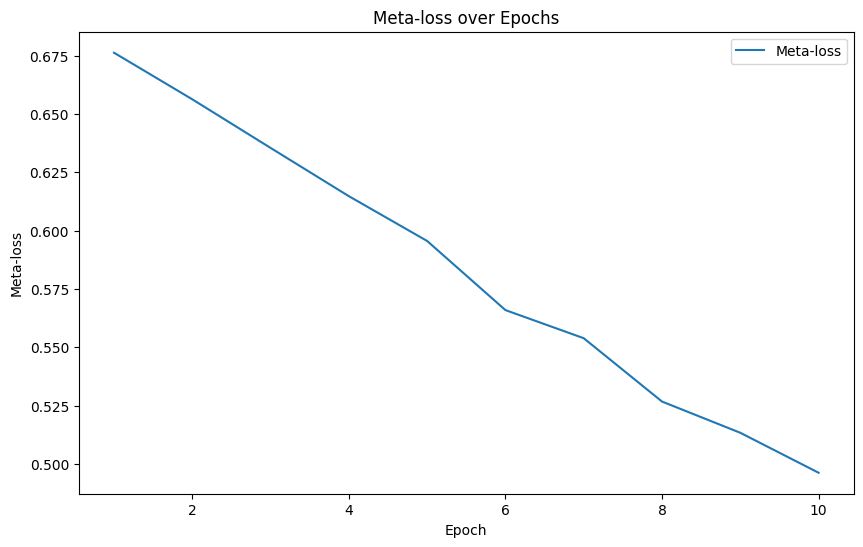

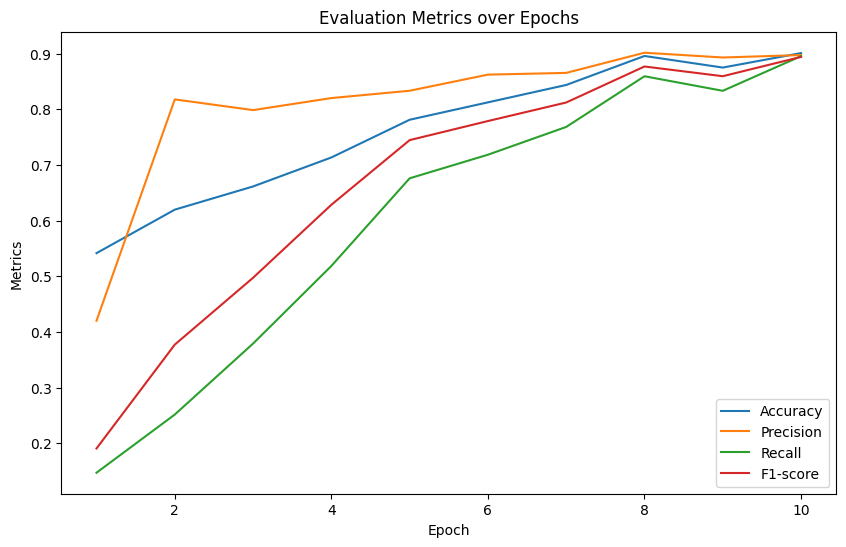

In [12]:
def plot_training_results(results: Dict[str, List[float]]):
    """
    Plot training results including meta-loss and evaluation metrics.

    Args:
        results: Dictionary containing meta-loss and evaluation metrics.
    """
    epochs = range(1, len(results["meta_loss"]) + 1)

    # Plot meta-loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["meta_loss"], label="Meta-loss")
    plt.xlabel("Epoch")
    plt.ylabel("Meta-loss")
    plt.title("Meta-loss over Epochs")
    plt.legend()
    plt.show()

    # Plot evaluation metrics
    if config.EVAL_METRICS:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, results["accuracy"], label="Accuracy")
        plt.plot(epochs, results["precision"], label="Precision")
        plt.plot(epochs, results["recall"], label="Recall")
        plt.plot(epochs, results["f1_score"], label="F1-score")
        plt.xlabel("Epoch")
        plt.ylabel("Metrics")
        plt.title("Evaluation Metrics over Epochs")
        plt.legend()
        plt.show()

plot_training_results(training_results)


=== Evaluating on Test2 Dataset ===
Accuracy:  0.5165
Precision: 0.5185
Recall:    0.4620
F1-score:  0.4886

Classification Report:
              precision    recall  f1-score   support

       Quark       0.51      0.57      0.54      5000
       Gluon       0.52      0.46      0.49      5000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000


Confusion Matrix (numbers):
[[2855 2145]
 [2690 2310]]


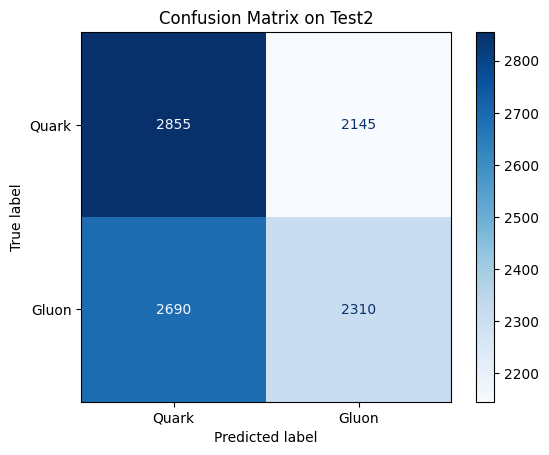

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

def evaluate_on_test2(model: nn.Module, test2_dataset: Dataset):
    print("\n=== Evaluating on Test2 Dataset ===")
    test2_loader = DataLoader(test2_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test2_loader:
            logits = model(X_batch)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(
        all_labels, all_preds, target_names=["Quark", "Gluon"], labels=[0, 1], zero_division=0
    ))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    print("\nConfusion Matrix (numbers):")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Quark", "Gluon"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix on Test2")
    plt.show()

if config.USE_TEST2:
    evaluate_on_test2(hybrid_model, test2_dataset)